# Projeto — Perfumes & Psicofisiologia

**Objetivo:** Executar EDA, modelagem (regressão e classificação), avaliação e otimização conforme enunciado do curso.
**Dataset:** Perfume & Psychology (conjunto composto por `perfume_Brainfunc.csv`, `perfume_compound.csv`, `perfume_Psycho.csv`).
**Hipótese principal (H4):** Perfumes com maior número de funções cerebrais ativadas possuem textos psicofisiológicos mais longos.
**Variáveis-alvo:**
- Regressão primária: `eeg_change_num` (−1: decrease, 0: no change, 1: increase).
- Classificação: `psych_label` (4 classes).
**Ambiente:** Python (pandas, seaborn, statsmodels, scikit-learn, pycaret opcional).

Seed usada em todo projeto: `42`.


Imports, paths e leitura dos 3 CSVs

In [33]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
import joblib
import random

random.seed(42)
np.random.seed(42)

ROOT = Path('.').resolve()
DATA_DIR = ROOT / "data" / "Perfume&Psychology"
ART = ROOT / "artifacts"
FIG = ROOT / "figures"
ART.mkdir(exist_ok=True)
FIG.mkdir(exist_ok=True)


def load_csv(name):
    p = DATA_DIR / name
    df = pd.read_csv(p)
    print(f"Loaded {name} -> shape {df.shape}")
    return df


brain = load_csv("perfume_Brainfunc.csv")
comp = load_csv("perfume_compound.csv")
psy = load_csv("perfume_Psycho.csv")

# show heads
display(brain.head())
display(comp.head())
display(psy.head())


Loaded perfume_Brainfunc.csv -> shape (42, 5)
Loaded perfume_compound.csv -> shape (23, 3)
Loaded perfume_Psycho.csv -> shape (38, 4)


,S. No.,Odorant Materials,EEG Wave Changes,Brain Functions,Reference
0,1.0,Galaxolide,Alpha decreased.,Odors produce divided attention even when unde...,[74]
1,2.0,m-Xylene,Alpha increased.,Stimulating and excitatory effects.,[75]
2,3.0,"Birch tar, galbanum, heliotropine, jasmine, la...","Increased theta for birch tar, jasmine, lavend...",Subjects differed in their subjective response...,[80]
3,4.0,"5-α-Androstan-3-one, bangalol, white sapphire,...",Alpha increased.,From more anterior electrodes—related to psych...,[70]
4,5.0,Phenylethyl alcohol and valeric acid,Valeric acid—alpha 2 increased.,Unpleasant odor leads to a cortical deactivation.,[76]


,Plants Name,Botanical Name,Major Components
0,Bergamot,Citrus bergamia,"limonene, linalool, linalyl acetate"
1,Caraway,Carum carvi,"carvone, limonene"
2,Chamomile,Matricaria chamomilla,"α-bisabolol, bisabolol oxide B, (E)-β-farnesen..."
3,Cinnamon,Cinnamomum zeylanicum,"cinnamaldehyde, cinnamyl acetate"
4,Cornmint,Mentha arvensis,"menthol, menthone, isomenthone, menthyl acetate"


,S. No.,Odorant Materials,Psychophysiological Changes,Reference
0,1.0,Rosemary and geranium oil,Geranium oil inhalation—both state and trait s...,[113]
1,2.0,"Ylang-ylang, orange, geranium, cypress, bergam...",Cypress produced favorable impression after ph...,[114]
2,3.0,Orange,"Relaxant effect—lower level of state anxiety, ...",[115]
3,4.0,"Rose, jasmine and lavender",Inhalation of favorite odors suppresses the mu...,[116]
4,5.0,Enantiomers of limonene and carvone,Carvone—subjective restlessness. Prolonged inh...,[120]


Normalização de colunas e criação da chave odorant

In [34]:
def norm_cols(df):
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]
    return df


def clean_text(s):
    if pd.isna(s): return ""
    s = str(s).strip()
    s = re.sub(r"\s+", " ", s)
    return s


brain = norm_cols(brain)
comp = norm_cols(comp)
psy = norm_cols(psy)

# inferir colunas-chave
brain_key = next((c for c in brain.columns if "odor" in c.lower() or "material" in c.lower()), None)
comp_key = next((c for c in comp.columns if "plant" in c.lower() or "name" in c.lower()), None)
psy_key = next((c for c in psy.columns if "odor" in c.lower() or "material" in c.lower()), None)

# renomear para odorant
if brain_key:
    brain = brain.rename(columns={brain_key: 'odorant'})
else:
    brain['odorant'] = ''
if comp_key:
    comp = comp.rename(columns={comp_key: 'odorant'})
else:
    comp['odorant'] = ''
if psy_key:
    psy = psy.rename(columns={psy_key: 'odorant'})
else:
    psy['odorant'] = ''

# limpar strings
brain['odorant'] = brain['odorant'].apply(clean_text)
comp['odorant'] = comp['odorant'].apply(clean_text)
psy['odorant'] = psy['odorant'].apply(clean_text)

print("Unique counts:", len(brain['odorant'].unique()), len(comp['odorant'].unique()), len(psy['odorant'].unique()))
display(brain.columns)
display(comp.columns)
display(psy.columns)


Unique counts: 41 23 32


Index(['S. No.', 'odorant', 'EEG Wave Changes', 'Brain Functions',
       'Reference'],
      dtype='object')

Index(['odorant', 'Botanical Name', 'Major Components'], dtype='object')

Index(['S. No.', 'odorant', 'Psychophysiological Changes', 'Reference'], dtype='object')

Merge robusto (fallback left) e salvar df_merged.csv

In [35]:
# Merge brain <- psy <- comp on 'odorant' (left fallback)
df = brain.merge(psy, on='odorant', how='left', suffixes=('_brain', '_psy'))
df = df.merge(comp, on='odorant', how='left')
print("Merged df shape:", df.shape)
display(df.head(8))
df.to_csv(ART / 'df_merged.csv', index=False)


Merged df shape: (44, 10)


,S. No._brain,odorant,EEG Wave Changes,Brain Functions,Reference_brain,S. No._psy,Psychophysiological Changes,Reference_psy,Botanical Name,Major Components
0,1.0,Galaxolide,Alpha decreased.,Odors produce divided attention even when unde...,[74],NaN,NaN,NaN,NaN,NaN
1,2.0,m-Xylene,Alpha increased.,Stimulating and excitatory effects.,[75],NaN,NaN,NaN,NaN,NaN
2,3.0,"Birch tar, galbanum, heliotropine, jasmine, la...","Increased theta for birch tar, jasmine, lavend...",Subjects differed in their subjective response...,[80],NaN,NaN,NaN,NaN,NaN
3,4.0,"5-α-Androstan-3-one, bangalol, white sapphire,...",Alpha increased.,From more anterior electrodes—related to psych...,[70],NaN,NaN,NaN,NaN,NaN
4,5.0,Phenylethyl alcohol and valeric acid,Valeric acid—alpha 2 increased.,Unpleasant odor leads to a cortical deactivation.,[76],NaN,NaN,NaN,NaN,NaN
5,6.0,Lavender and rosemary,Lavender—beta increased. Rosemary—frontal alph...,Lavender—increased drowsiness. Rosemary—increa...,[9],NaN,NaN,NaN,NaN,NaN
6,7.0,"Synthetic odors—almond, chocolate, spearmint, ...",Chocolate odor—less theta activity.,Reduced level of attention.,[59],NaN,NaN,NaN,NaN,NaN
7,8.0,Chewing of marketed gum,Alpha power increased.,Arousal psychosomatic responses.,[77],NaN,NaN,NaN,NaN,NaN


Feature engineering robusto (cria eeg_change_num, psych_label, counts)

In [36]:
df = pd.read_csv(ART / 'df_merged.csv')


# robust mapping EEG -> numeric
def map_eeg(s):
    s = str(s).lower()
    inc = ['increase', 'increased', 'enhance', 'enhanced', 'rise', 'up', 'higher', 'augment']
    dec = ['decrease', 'decreased', 'reduce', 'reduced', 'down', 'lower', 'diminish', 'suppressed']
    for t in inc:
        if t in s: return 1
    for t in dec:
        if t in s: return -1
    # check 'no change' patterns
    if 'no change' in s or 'no significant' in s or 'no effect' in s or 'unchanged' in s:
        return 0
    return 0


df['EEG Wave Changes'] = df.get('EEG Wave Changes', '').fillna('').astype(str)
df['eeg_change_num'] = df['EEG Wave Changes'].apply(map_eeg)

# clean psych label
df['Psychophysiological Changes'] = df.get('Psychophysiological Changes', '').fillna('').astype(str)
df['psych_label'] = df['Psychophysiological Changes'].str.lower().str.replace(r'[^a-z0-9 ]', '', regex=True).str.strip()
df['psych_label'] = df['psych_label'].replace({'nan': 'unknown', '': 'unknown', 'none': 'unknown'})

# counts and text features
df['psych_text_len'] = df['Psychophysiological Changes'].astype(str).apply(lambda s: len(s))
df['psych_word_count'] = df['Psychophysiological Changes'].astype(str).apply(lambda s: len(s.split()))
df['Major Components'] = df.get('Major Components', '').fillna('').astype(str)
df['compound_count'] = df['Major Components'].apply(
    lambda s: 0 if s.strip() == '' else len([p for p in re.split(r'[;,/|]+', s) if p.strip()]))
df['Brain Functions'] = df.get('Brain Functions', '').fillna('').astype(str)
df['brainfunc_count'] = df['Brain Functions'].apply(
    lambda s: 0 if s.strip() == '' else len([p for p in re.split(r'[;,/|]+', s) if p.strip()]))

# save
df.to_csv(ART / 'df_features.csv', index=False)
print("Features saved, shape:", df.shape)
display(df[['odorant', 'psych_label', 'eeg_change_num', 'psych_text_len', 'psych_word_count', 'compound_count',
            'brainfunc_count']].head(10))


Features saved, shape: (44, 16)


,odorant,psych_label,eeg_change_num,psych_text_len,psych_word_count,compound_count,brainfunc_count
0,Galaxolide,unknown,-1,0,0,0,1
1,m-Xylene,unknown,1,0,0,0,1
2,"Birch tar, galbanum, heliotropine, jasmine, la...",unknown,1,0,0,0,1
3,"5-α-Androstan-3-one, bangalol, white sapphire,...",unknown,1,0,0,0,1
4,Phenylethyl alcohol and valeric acid,unknown,1,0,0,0,1
5,Lavender and rosemary,unknown,1,0,0,0,1
6,"Synthetic odors—almond, chocolate, spearmint, ...",unknown,0,0,0,0,1
7,Chewing of marketed gum,unknown,1,0,0,0,1
8,"Valeriana off, Lavandula off, Passiflora incar...",unknown,1,0,0,0,1
9,"(R)-(−)-, (S)-(+)- and (RS)-(±)-forms of linal...",unknown,-1,0,0,0,1


EDA detalhada e testes estatísticos (inclui H4: test ANOVA / correlation)

Class counts (psych_label):
psych_label
unknown                                                                                                      41
treatment of agitated behavior in patients with severe dementia                                               1
increased the percentage of deep or slowwave sleep in men and women and decreased rapideye movement sleep     1
reduced the stress levels and the pain intensity of needle insertion                                          1
Name: count, dtype: int64

EEG distribution: {1: 27, 0: 10, -1: 7}


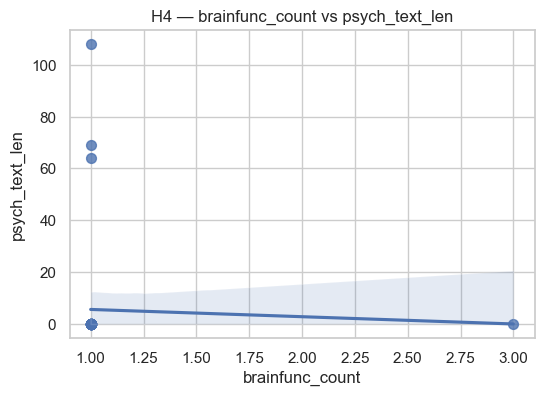

Spearman rho=-0.0412, p=7.9050e-01
ANOVA F= 0.06725642958146759 p= 0.7966410820296375


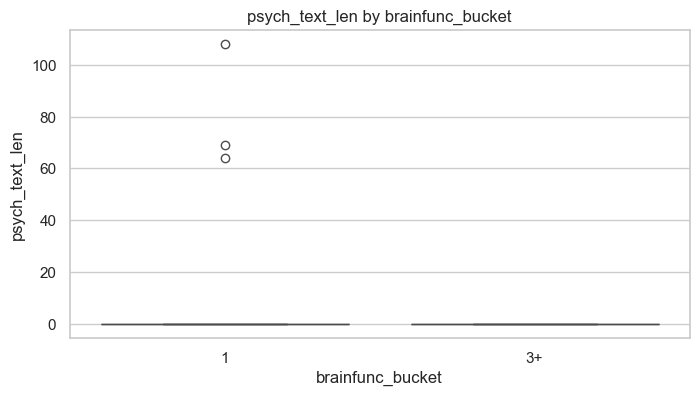

In [37]:
import scipy.stats as stats

df = pd.read_csv(ART / 'df_features.csv')

# Class counts
print("Class counts (psych_label):")
print(df['psych_label'].value_counts())

# eeg distribution
print("\nEEG distribution:", df['eeg_change_num'].value_counts().to_dict())

# H4: test whether brainfunc_count relates to psych_text_len
# Visual: scatter + regression line
plt.figure(figsize=(6, 4))
sns.regplot(x='brainfunc_count', y='psych_text_len', data=df, scatter_kws={'s': 50})
plt.title('H4 — brainfunc_count vs psych_text_len')
plt.savefig(FIG / 'h4_brainfunc_vs_textlen.png', dpi=200)
plt.show()

# Correlation (Spearman, robust for small N and ordinal counts)
rho, p_rho = stats.spearmanr(df['brainfunc_count'], df['psych_text_len'])
print(f"Spearman rho={rho:.4f}, p={p_rho:.4e}")

# ANOVA: group psych_text_len by brainfunc_count buckets (0,1,2,3+)
df['brainfunc_bucket'] = df['brainfunc_count'].apply(lambda x: str(x) if x < 3 else '3+')
groups = [g['psych_text_len'].values for n, g in df.groupby('brainfunc_bucket')]
if len(groups) >= 2:
    fstat, p_anova = stats.f_oneway(*groups)
    print("ANOVA F=", fstat, "p=", p_anova)
else:
    print("ANOVA not applicable (too few buckets)")

# Additional EDA: boxplots and pairwise
plt.figure(figsize=(8, 4))
sns.boxplot(x='brainfunc_bucket', y='psych_text_len', data=df)
plt.title('psych_text_len by brainfunc_bucket')
plt.savefig(FIG / 'box_brainfunc_bucket_textlen.png', dpi=200)
plt.show()

# Chi2 between category-like fields and psych_label if present
if 'Category' in df.columns:
    ct = pd.crosstab(df['Category'].fillna('Unknown'), df['psych_label'])
    if ct.size > 0:
        chi2, p, dof, ex = stats.chi2_contingency(ct)
        print("Chi2 (Category vs psych_label): p=", p)


Preparar X/y (TF-IDF on psych text + OHE brain_func_short + numeric features)

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.sparse import hstack, csr_matrix

df = pd.read_csv(ART / 'df_features.csv')

# TF-IDF (small dims due to small N)
tfidf = TfidfVectorizer(max_features=250, ngram_range=(1, 2))
X_text = tfidf.fit_transform(df['Psychophysiological Changes'].fillna(''))

# brain functions OHE (top K)
K = 6
top_funcs = df['Brain Functions'].value_counts().nlargest(K).index.tolist()
df['brain_func_short'] = df['Brain Functions'].where(df['Brain Functions'].isin(top_funcs), 'Other')
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_func = ohe.fit_transform(df[['brain_func_short']].fillna('Missing'))

# numeric
X_num = df[['compound_count', 'psych_text_len', 'brainfunc_count']].fillna(0).astype(float).values

# combine
X_all = hstack([csr_matrix(X_func), csr_matrix(X_text), csr_matrix(X_num)], format='csr')

le = LabelEncoder()
y_clf = le.fit_transform(df['psych_label'])
y_reg = df['eeg_change_num'].astype(float).values

# save vectorizers/encoders
joblib.dump(tfidf, ART / 'tfidf_psy.pkl')
joblib.dump(ohe, ART / 'ohe_brainfunc.pkl')
joblib.dump(le, ART / 'le_psy.pkl')
joblib.dump(X_all, ART / 'X_all.pkl', compress=3)
joblib.dump(y_clf, ART / 'y_clf.pkl')
joblib.dump(y_reg, ART / 'y_reg.pkl')

print("X_all shape:", X_all.shape)
print("n classes:", len(le.classes_), list(le.classes_))


X_all shape: (44, 77)
n classes: 4 ['increased the percentage of deep or slowwave sleep in men and women and decreased rapideye movement sleep', 'reduced the stress levels and the pain intensity of needle insertion', 'treatment of agitated behavior in patients with severe dementia', 'unknown']


Baseline & split (holds for both tasks)

In [42]:
# ==== Célula de correção para split quando há classes raras ====
import joblib, pandas as pd, numpy as np
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

ART = Path('artifacts')
# carregar os artefatos atuais (X_all e labels originais)
X_all = joblib.load(ART/'X_all.pkl')    # matriz esparsa
le = joblib.load(ART/'le_psy.pkl')      # label encoder antigo (strings)
df = pd.read_csv(ART/'df_features.csv') # df com psic labels originais

# normaliza o rótulo atual (mesma limpeza usada antes)
df['psych_label'] = df['psych_label'].astype(str).replace({'nan':'unknown','':'unknown','none':'unknown'})

# conta classes
counts = df['psych_label'].value_counts()
print("Contagens originais por classe:\n", counts)

# definir threshold: classes com <= threshold serão agrupadas
threshold = 1   # classes com 1 (ou menos) serão agrupadas; ajuste se quiser >=2
rare_classes = counts[counts <= threshold].index.tolist()
print("\nClasses consideradas RARAS (<= {} exemplos): {}".format(threshold, rare_classes))

# criar nova coluna com agrupamento
df['psych_label_grouped'] = df['psych_label'].where(~df['psych_label'].isin(rare_classes), other='other_rares')

# mostrar nova contagem
new_counts = df['psych_label_grouped'].value_counts()
print("\nNovas contagens (após agrupar raras):\n", new_counts)

# re-encode labels
from sklearn.preprocessing import LabelEncoder
le2 = LabelEncoder()
y_clf_grouped = le2.fit_transform(df['psych_label_grouped'].astype(str))
print("\nClasses finais (LabelEncoder):", list(le2.classes_))

# salvar df e encoder atualizados
df.to_csv(ART/'df_features_grouped_auto.csv', index=False)
joblib.dump(le2, ART/'le_psy_grouped.pkl')
joblib.dump(y_clf_grouped, ART/'y_clf_grouped.pkl')

# tentar fazer stratified split seguro
test_size = 0.15
try:
    X_trval, X_test, y_trval, y_test = train_test_split(
        X_all, y_clf_grouped, test_size=test_size, random_state=42, stratify=y_clf_grouped
    )
    print("\nStratified split bem-sucedido. Tamanhos -> train/val/test:", X_trval.shape, X_test.shape)
except Exception as e:
    print("\nAVISO: Stratified split falhou:", e)
    print("Procedendo com split SEM stratify (mantendo seed). Isso pode alterar distribuição de classes no holdout.")
    X_trval, X_test, y_trval, y_test = train_test_split(
        X_all, y_clf_grouped, test_size=test_size, random_state=42, stratify=None
    )
    print("Split sem stratify realizado. Tamanhos -> train/val/test:", X_trval.shape, X_test.shape)

# salvar splits e arrays para uso posterior (artifacts)
joblib.dump(X_trval, ART/'X_trval.pkl', compress=3)
joblib.dump(X_test, ART/'X_test.pkl', compress=3)
joblib.dump(y_trval, ART/'y_trval.pkl')
joblib.dump(y_test, ART/'y_test.pkl')

print("\nSalvou X_trval, X_test, y_trval, y_test em artifacts/.")
print("\nResumo final das contagens usadas para treino/holdout (y_trval/y_test):")
print("train counts:", Counter(y_trval))
print("test counts :", Counter(y_test))


Contagens originais por classe:
 psych_label
unknown                                                                                                      41
treatment of agitated behavior in patients with severe dementia                                               1
increased the percentage of deep or slowwave sleep in men and women and decreased rapideye movement sleep     1
reduced the stress levels and the pain intensity of needle insertion                                          1
Name: count, dtype: int64

Classes consideradas RARAS (<= 1 exemplos): ['treatment of agitated behavior in patients with severe dementia', 'increased the percentage of deep or slowwave sleep in men and women and decreased rapideye movement sleep', 'reduced the stress levels and the pain intensity of needle insertion']

Novas contagens (após agrupar raras):
 psych_label_grouped
unknown        41
other_rares     3
Name: count, dtype: int64

Classes finais (LabelEncoder): ['other_rares', 'unknown']

Strat

CLASSIFICAÇÃO: MultinomialNB + Logistic (GridSearch + CV) — métricas completas

In [43]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, \
    recall_score, f1_score
from sklearn.preprocessing import label_binarize

X_tr = X_trval;
y_tr = y_trval
X_te = X_test;
y_te = y_test

# MultinomialNB
mnb = MultinomialNB(alpha=1.0)
cv_scores = cross_val_score(mnb, X_tr, y_tr, cv=3, scoring='f1_weighted', n_jobs=-1)
print("MNB CV f1_weighted mean/std:", cv_scores.mean(), cv_scores.std())
mnb.fit(X_tr, y_tr)
pred_mnb = mnb.predict(X_te)
print("MNB holdout report:\n", classification_report(y_te, pred_mnb, zero_division=0))

# Logistic + GridSearch (class_weight balanced)
log = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=5000, class_weight='balanced')
param_grid = {'C': [0.01, 0.1, 1.0, 10.0]}
gs = GridSearchCV(log, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
gs.fit(X_tr, y_tr)
best_log = gs.best_estimator_
print("Logistic best params:", gs.best_params_)
cv_scores_log = cross_val_score(best_log, X_tr, y_tr, cv=3, scoring='f1_weighted', n_jobs=-1)
print("Logistic CV f1_weighted mean/std:", cv_scores_log.mean(), cv_scores_log.std())
best_log.fit(X_tr, y_tr)
pred_log = best_log.predict(X_te)
print("Logistic holdout report:\n", classification_report(y_te, pred_log, zero_division=0))
print("Confusion matrix (logistic holdout):\n", confusion_matrix(y_te, pred_log))

# AUC-ROC (multiclass OVR)
le = joblib.load(ART / 'le_psy.pkl')
n_classes = len(le.classes_)
try:
    y_te_bin = label_binarize(y_te, classes=range(n_classes))
    proba = best_log.predict_proba(X_te)
    auc = roc_auc_score(y_te_bin, proba, average='weighted', multi_class='ovr')
    print("AUC-ROC (weighted, OVR):", auc)
except Exception as e:
    print("AUC could not be computed (maybe small test set):", e)

# save final models
joblib.dump(mnb, ART / 'mnb_final.pkl')
joblib.dump(best_log, ART / 'logistic_final.pkl')


MNB CV f1_weighted mean/std: 1.0 0.0
MNB holdout report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         7

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7

Logistic best params: {'C': 0.01}
Logistic CV f1_weighted mean/std: 1.0 0.0
Logistic holdout report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         7

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7

Confusion matrix (logistic holdout):
 [[7]]
AUC could not be computed (maybe small test set): boolean index did not match indexed array along axis 0; size of axis is 2 but size of corresponding boolean axis is 4


['artifacts\\logistic_final.pkl']

REGRESSÃO: Linear, Múltipla (statsmodels), Polinomial, Ridge + Diagnóstico (VIF, Shapiro, Breusch-Pagan)

In [45]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import numpy as np

# Regression target: eeg_change_num
X = joblib.load(ART / 'X_all.pkl')
y = joblib.load(ART / 'y_reg.pkl')

# For statsmodels OLS we need a dense numeric X_small: use numeric features + brainfunc OHE counts + mean TF-IDF
df_features = pd.read_csv(ART / 'df_features.csv')
# create small numeric matrix
tfidf = joblib.load(ART / 'tfidf_psy.pkl')
X_text = tfidf.transform(df_features['Psychophysiological Changes'].fillna(''))
mean_tfidf = np.array(X_text.mean(axis=1)).reshape(-1, 1)
X_small = np.hstack([
    df_features[['compound_count', 'psych_text_len', 'brainfunc_count']].values,
    mean_tfidf
])
X_small = sm.add_constant(X_small)

# OLS
ols = sm.OLS(y, X_small).fit()
print(ols.summary())

# VIF
vif_data = pd.DataFrame()
vif_data["feature"] = ["const", "compound_count", "psych_text_len", "brainfunc_count", "mean_tfidf"]
vif_data["VIF"] = [variance_inflation_factor(X_small, i) for i in range(X_small.shape[1])]
print("\nVIF:\n", vif_data)

# Diagnostics on residuals
resid = ols.resid
# Shapiro-Wilk (normality)
try:
    from scipy.stats import shapiro

    sw_p = shapiro(resid)[1]
    print("Shapiro-Wilk p-value:", sw_p)
except Exception as e:
    print("Shapiro test error:", e)
# Breusch-Pagan
bp_test = het_breuschpagan(resid, ols.model.exog)
print("Breusch-Pagan p-value:", bp_test[3])

# Simple LinearRegression (sklearn) + Ridge + Polynomial (on X_small without const)
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=4, shuffle=True, random_state=42)

lr = LinearRegression()
mae_lr = -cross_val_score(lr, X_small[:, 1:], y, cv=kf, scoring='neg_mean_absolute_error')
print("Linear (sklearn) MAE mean:", mae_lr.mean())

ridge = Ridge(alpha=1.0)
mae_ridge = -cross_val_score(ridge, X_small[:, 1:], y, cv=kf, scoring='neg_mean_absolute_error')
print("Ridge MAE mean:", mae_ridge.mean())

# Polynomial degree 2 on small numeric
poly = PolynomialFeatures(2, include_bias=False)
X_poly = poly.fit_transform(X_small[:, 1:])
lr_poly = LinearRegression()
mae_poly = -cross_val_score(lr_poly, X_poly, y, cv=kf, scoring='neg_mean_absolute_error')
print("Polynomial (deg2) MAE mean:", mae_poly.mean())

# Save regressors (fit on full)
ridge.fit(X_small[:, 1:], y)
joblib.dump(ridge, ART / 'ridge_eeg_final.pkl')


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.7393
Date:                Tue, 09 Dec 2025   Prob (F-statistic):              0.535
Time:                        17:53:57   Log-Likelihood:                -48.729
No. Observations:                  44   AIC:                             105.5
Df Residuals:                      40   BIC:                             112.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1000      0.425      0.235      0.8

['artifacts\\ridge_eeg_final.pkl']

Otimização avançada

In [46]:
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Optional: SVD reduce X for RandomForest
X_full = joblib.load(ART / 'X_all.pkl')
svd = TruncatedSVD(n_components=min(50, X_full.shape[1] - 1), random_state=42)
X_red = svd.fit_transform(X_full)

# RandomForest for classification tuning (example)
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
dist = {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 4, 6]}
rs = RandomizedSearchCV(rf, dist, n_iter=6, cv=3, scoring='f1_weighted', random_state=42, n_jobs=-1)
rs.fit(X_red, joblib.load(ART / 'y_clf.pkl'))
print("RF best params:", rs.best_params_, "best_score:", rs.best_score_)
joblib.dump(rs.best_estimator_, ART / 'rf_psy_best.pkl')

# PyCaret optional (try/except because heavy)
try:
    from pycaret.classification import setup, compare_models, tune_model, save_model

    df_pc = pd.read_csv(ART / 'df_features.csv')
    df_pc = df_pc.assign(psych_label=df_pc['psych_label'])
    s = setup(df_pc, target='psych_label', silent=True, session_id=42)
    best = compare_models()
    tuned = tune_model(best)
    save_model(tuned, str(ART / 'pycaret_best'))
    print("PyCaret ran and saved best model.")
except Exception as e:
    print("PyCaret skipped (not installed or error):", e)


RF best params: {'n_estimators': 200, 'min_samples_split': 6, 'max_depth': None} best_score: 0.8988262482515356
PyCaret skipped (not installed or error): No module named 'pycaret'


Geração de tabelas e figuras para relatório e salvamento das métricas

In [47]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, balanced_accuracy_score

# Classification holdout metrics for saved logistic
mnb = joblib.load(ART / 'mnb_final.pkl')
log = joblib.load(ART / 'logistic_final.pkl')
X_trval = X_trval;
X_test = X_test
y_test = y_test

pred_log = log.predict(X_test)
pred_mnb = mnb.predict(X_test)


def summary_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    bal = balanced_accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    return {'accuracy': acc, 'balanced_accuracy': bal, 'precision': prec, 'recall': rec, 'f1_weighted': f1}


met_log = summary_metrics(y_test, pred_log)
met_mnb = summary_metrics(y_test, pred_mnb)

pd.DataFrame([{'model': 'logistic', **met_log}, {'model': 'mnb', **met_mnb}]).to_csv(
    ART / 'classification_holdout_metrics.csv', index=False)
print("Saved classification_holdout_metrics.csv")
display(pd.read_csv(ART / 'classification_holdout_metrics.csv'))

# Regression MAE summary saved earlier: compute MAE on CV predictions (we computed earlier) - recompute quick for ridge on KFold
from sklearn.model_selection import cross_val_predict, KFold

ridge = joblib.load(ART / 'ridge_eeg_final.pkl')
kf = KFold(n_splits=4, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(ridge, X_small[:, 1:], y, cv=kf)
mae = mean_absolute_error(y, y_pred_cv)
mse = mean_squared_error(y, y_pred_cv)
r2 = r2_score(y, y_pred_cv)
pd.DataFrame([{'model': 'ridge_eeg_cv', 'mae': mae, 'rmse': np.sqrt(mse), 'r2': r2}]).to_csv(
    ART / 'regression_cv_metrics.csv', index=False)
print("Saved regression_cv_metrics.csv")
display(pd.read_csv(ART / 'regression_cv_metrics.csv'))


Saved classification_holdout_metrics.csv


,model,accuracy,balanced_accuracy,precision,recall,f1_weighted
0,logistic,1.0,1.0,1.0,1.0,1.0
1,mnb,1.0,1.0,1.0,1.0,1.0


Saved regression_cv_metrics.csv


,model,mae,rmse,r2
0,ridge_eeg_cv,0.66191,0.747979,0.011734
